# Cluster Area Order Parameter Analysis

This notebook is the first version of an analysis of ant temperature transition videos that seeks to establish an order parameter to quantify the change from an ordered to a disordered state (and vice versa). The basic idea is as follows. When ants behave most orderly, they cluster up closely in a bunch. This cluster has an area (as a percentage of the total arena area) that is quite small. When ants behave less orderly but not fully disorderly, they start moving in a recognizable pattern, not randomly. This might look like ants moving in a circle. In this case, the area that they are effectively covering is greater than that in the most orderly state but still restricted–they do not cover the entire arena. Finally, when ants move in a disorderly manner, they cover the entire arena, and move seemingly randomly. In this case, the total area they collectively cover is around 100% of the arena's area. This suggests a way of quantifying the level of order: calculate the total area covered by ants at a given moment of time, as a percentage of the arena's area. This should allow one to distinguish between the three types of behavior discussed above: most orderly (inactive), active but orderly, and disorderly. This method would not be able to distinsguish between active and inactive disorder, but that is arguably beside the point and not really what is sought. Moreover, however, it is hard to conceive when ants would be disordered but inatice (immobile), since that is an unnatural state for them to assume.

The code below executes this idea. At every frame in a video, it identifies all the ants it can. It is imperfect at doing so but that does not matter much because when it fails it is usually because there are a lot of ants clustered close together and it cannot distinguish between them. That means that the worst case will be an underestimate of the area, which is fine if that is due to tight ant clusters. After finding all the locations, it caries out a clustering algorithm to find $k$ clusters. This variable, $k$, is a predetermined parameter. Ideally, it would be dynamically set, but so far I haven't come up with a good way of doing this. Currently, I am using $k=9$, as conceptually this comparmentalizes the arena into 9 equal areas and checks for clusters in each of these areas. For bigger arenas, one could increase the number of clusters from 9 to 16 or 25 (a square). The parameter is arbitrary, but it makes sense that one would want the number to be substantially greater than 1 in order to be able to account for random ants that may be exploring the arena alone outside of the main cluster, who shouldn't count much towards the order parameter calculation. It also allows for the detection of active order, in which ants will be quite spread out over the arena but in a pattern that does not cover the entire area of the arena. This can only be detected by allowing for more clusters in order to avoid parts of the area without any significant concentration of ants. After all clusters are found, their area is calculated and added together, which is then divided by the total arena area to determine the percentage of the arena being covered by ants.

The results below suggest this is a fairly useful metric to quantify transitions between ordered and disordered states.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [2]:
# Open the video file
video_file = 'xavier_disordered_response_to_temp_perturbation.mp4'
cap = cv2.VideoCapture(video_file)

if not cap.isOpened():
    print("Error opening video file")

# Initialize lists to store data over time
mean_distances = []
variances = []
# Set minimum and maximum contour areas to filter ants
min_contour_area = 100  # Adjust this value based on your needs
#max_contour_area = 5000  # Adjust this value based on your needs
frame_num=0

######## access a particular frame ##############
# Frame number to retrieve (in your case, the 23rd frame)
frame_number = 100

# Initialize a frame counter
current_frame = 0

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Break the loop if we've reached the end of the video or the desired frame
    if not ret or current_frame == frame_number:
        break

    # Increment the frame counter
    current_frame += 1
########################################################

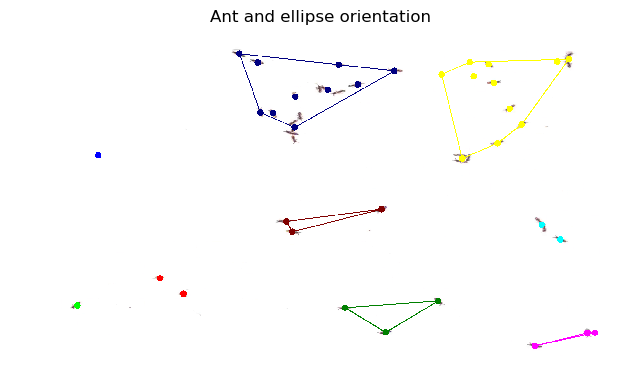

In [15]:
import numpy as np
from scipy.cluster.hierarchy import linkage,fcluster
from scipy.spatial import ConvexHull

# Convert the frame to grayscale for contour detection
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
inverted_gray = 255-gray
#_, thresholded = cv2.threshold(inverted_gray, 128, 255, cv2.THRESH_BINARY)

# Find contours in the grayscale frame
contours, _ = cv2.findContours(inverted_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours and centroids on the original frame
frame_with_clusters = frame.copy()

angles = []
centroids = []

for contour in contours:
    # Calculate the area of each contour
    contour_area = cv2.contourArea(contour)

    # Check if the contour area is within the specified range
    if min_contour_area <= contour_area:
        # Calculate the centroid of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0
        centroids.append([cX, cY])
        
        # # Draw the contour and centroid on the frame
        # cv2.drawContours(frame_with_clusters, [contour], 0, (0, 255, 0), 2)  # Green contour
        # cv2.circle(frame_with_clusters, (cX, cY), 5, (0, 0, 255), -1)  # Red centroid

X = np.array(centroids)
k = 9
Z = linkage(X,'centroid')
cluster_assignments = fcluster(Z,k,'maxclust')
# print(cluster_assignments)

color_map = {1: (0,0,255),
             2: (0,255,0),
             3: (255,0,0),
             4: (255,255,0),
             5: (255,0,255),
             6: (0,255,255),
             7: (128,0,0),
             8: (0,128,0),
             9: (0,0,128)}
for idx,c in enumerate(cluster_assignments):
    cv2.circle(frame_with_clusters, (X[idx][0], X[idx][1]), 10, color_map[c], -1)
    
for i in range(max(cluster_assignments)):
    idxs = [idx for idx,x in enumerate(cluster_assignments) if x == i+1]
    cluster_points = [p for idx,p in enumerate(X) if idx in idxs]
    if(len(cluster_points) < 3):
        continue
#     print(cluster_points)
    hull = cv2.convexHull(np.array(cluster_points), False)
#     print(hull)
    cv2.drawContours(frame_with_clusters, [hull], 0, color_map[i+1], 2)
    
    hull_area = (ConvexHull(cluster_points)).volume
#     print(int(hull_area))
    
# Display the frame with contours and centroids
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(frame_with_clusters, cv2.COLOR_BGR2RGB))
plt.title('Ant and ellipse orientation')
plt.axis('off')
plt.show()

# # Optionally, you can also display the thresholded image for reference
# display(Image(filename='thresholded_image.jpg'))


## Functions to Calculate Order Parameter

In [17]:
######## iterate through all video frames #####################
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage,fcluster
from scipy.spatial import ConvexHull

def calculate_cluster_area_order(centroids, frame_area):
    X = np.array(centroids)
    Z = linkage(X,'centroid')
    cluster_assignments = fcluster(Z,9,'maxclust')
    
    total_area = 0
    for i in range(max(cluster_assignments)):
        idxs = [idx for idx,x in enumerate(cluster_assignments) if x == i+1]
        cluster_points = [p for idx,p in enumerate(X) if idx in idxs]
        if(len(cluster_points) < 3):
            continue
        try:
            total_area += (ConvexHull(cluster_points)).volume
        except:
            continue
    
    return total_area/frame_area

def get_cluster_order(video_file):
    # Open the video file
    cap = cv2.VideoCapture(video_file)

    # Initialize lists to store data over time
    cluster_area_orders=[]
    
    # Set minimum and maximum contour areas to filter ants
    min_contour_area = 15  # Adjust this value based on your needs
    #max_contour_area = 5000  # Adjust this value based on your needs
    
    frame_num=0
    while True:
        frame_num+=1
        # Read a frame from the video
        ret, frame = cap.read()

        # Break the loop if we've reached the end of the video
        if not ret:
            break

        # Convert the frame to grayscale for contour detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        inverted_gray = 255-gray
        _, thresholded = cv2.threshold(inverted_gray, 128, 255, cv2.THRESH_BINARY)

        # Find contours in the grayscale frame
        contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        centroids = []

        for contour in contours:
            # Calculate the area of each contour
            contour_area = cv2.contourArea(contour)

            # Check if the contour area is within the specified range
            if min_contour_area <= contour_area:
                if len(contour) >=3:
                    # Calculate the centroid of the contour
                    M = cv2.moments(contour)
                    if M["m00"] != 0:
                        cX = int(M["m10"] / M["m00"])
                        cY = int(M["m01"] / M["m00"])
                    else:
                        cX, cY = 0, 0
                    centroids.append([cX,cY])
        
        frame_area = frame.shape[0]*frame.shape[1]
        
        cluster_area_order = calculate_cluster_area_order(centroids,frame_area)
        cluster_area_orders.append(cluster_area_order)

    # Release the video capture
    cap.release()

    # Create a time array (frame index) for the x-axis
    time = np.arange(len(cluster_area_orders))
    return time, cluster_area_orders

In [6]:
def smooth(time,data,window_size):
    data_s = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    time_s = time[(window_size-1)//2 : -(window_size-1)//2]
    return time_s,data_s

## Calculating Order Parameter for Active Ordered and Disordered Ants

The first video (disordered_response) shows ants moving seemingly randomly across an arena. It is clear that they constantly cover a substantial proportion of the total possible area.

The second video (ordered_response) shows ants moving constantly around an arena but in a clearly ordered pattern. They move in a distinguishable rounded square/rectangle pattern. As such, the area that they consistently cover is much smaller than in the first video. This difference is clearly identifiable in the graphs of the order parameter below.

In [18]:
d_video_file = 'xavier_disordered_response_to_temp_perturbation.mp4'
d_t,d_cluster = get_cluster_order(d_video_file)

o_video_file = 'xavier_ordered_response_to_temp_perturbation.mp4'
o_t,o_cluster = get_cluster_order(o_video_file)

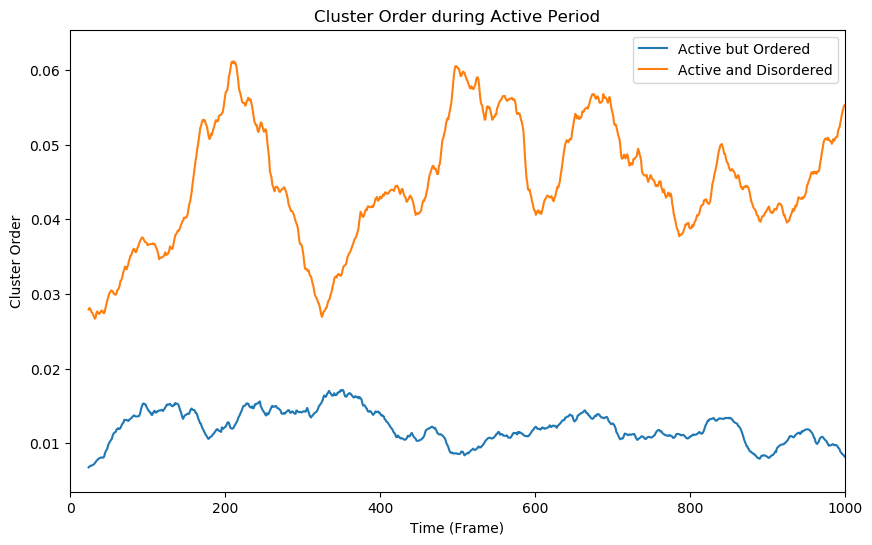

In [28]:
# Set the window size for the moving average
window_size = 50  # Adjust this based on your preference
# Calculate the moving average without end effects using NumPy
[o_t_s,o_cluster_s] = smooth(o_t,o_cluster,window_size)
[d_t_s,d_cluster_s] = smooth(d_t,d_cluster,window_size)


# Plot variance over mean distance as a function of time
plt.figure(figsize=(10, 6))
# plt.plot(d_t,d_cluster, label='Disordered')
# plt.plot(o_t,o_cluster,label='Ordered')
plt.plot(o_t_s, o_cluster_s, label=f'Active but Ordered', linestyle='-') # Order Smoothed (Window Size {window_size})
plt.plot(d_t_s, d_cluster_s, label=f'Active and Disordered', linestyle='-') # Disorder Smoothed (Window Size {window_size})
plt.xlabel('Time (Frame)')
plt.ylabel('Cluster Order')
plt.title('Cluster Order during Active Period')
plt.legend()
plt.grid(False)
# plt.ylim([0.5,1])
plt.xlim([0,1000])
plt.savefig('temp_active_comparison.png')
plt.show()

## Calculating Order Parameter for Initially Inactive Ants

Similar to before, but now both videos starts with ants in an inactive ordered state (in a tight cluster). In one of the videos, they begin transitioning to a less ordered state (still unclear whether disordered or simply actively ordered). In the other they stay fairly inative and ordered.

In [20]:
sm01_video_file = 'xavier_pnas_sm01_crop.mp4'
sm01_t,sm01_cluster = get_cluster_order(sm01_video_file)

sm02_video_file = 'xavier_pnas_sm02_crop.mp4'
sm02_t,sm02_cluster = get_cluster_order(sm02_video_file)

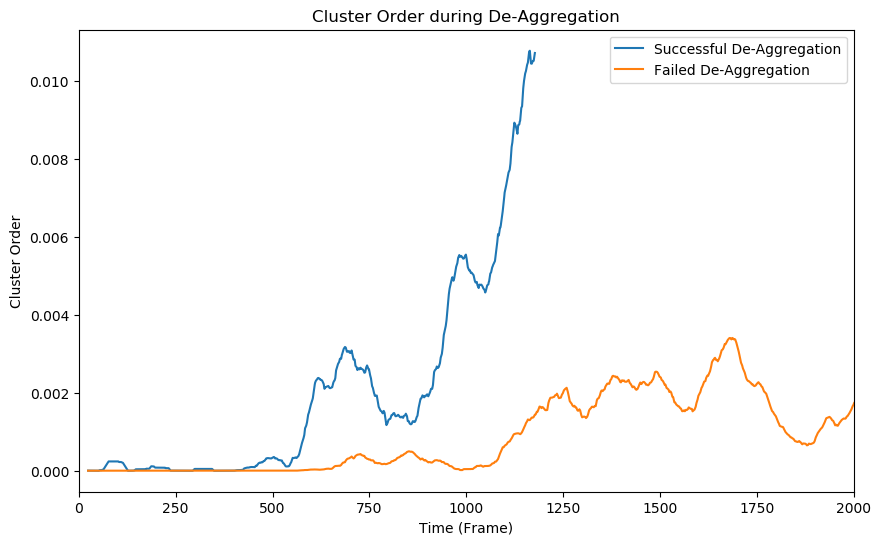

In [27]:
# Set the window size for the moving average
window_size = 50  # Adjust this based on your preference
# Calculate the moving average without end effects using NumPy
[sm01_t_s,sm01_cluster_s] = smooth(sm01_t,sm01_cluster,window_size)
[sm02_t_s,sm02_cluster_s] = smooth(sm02_t,sm02_cluster,window_size)


# Plot variance over mean distance as a function of time
plt.figure(figsize=(10, 6))
# plt.plot(sm01_t,sm01_nematic, label='Disordered')
# plt.plot(sm02_t,sm02_nematic,label='Ordered')
plt.plot(sm01_t_s, sm01_cluster_s, label=f'Successful De-Aggregation', linestyle='-') # Successful Smoothed (Window Size {window_size})
plt.plot(sm02_t_s, sm02_cluster_s, label=f'Failed De-Aggregation', linestyle='-') # Failed transition Smoothed (Window Size {window_size})
plt.xlabel('Time (Frame)')
plt.ylabel('Cluster Order')
plt.title('Cluster Order during De-Aggregation')
plt.legend()
plt.grid(False)
# plt.ylim([0.0,0.01])
plt.xlim([0,2000])
plt.savefig('temp_inactive_transition.png')
plt.show()

## END